<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/04_Modeling_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelization - Neural network based on the extracted features

In this notebook we will teach the neural network based on the features we have extracted from the wikidata and wikipedia.
We will try a neural network model

In [1]:
# Import of the training data

from google.colab import files

# Import of moduls

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
import math

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

train_df = pd.read_json('/content/drive/MyDrive/France_Poland_multilanguage_shared_folder/train_df_complete.json', orient="records", lines=True)
dev_df = pd.read_json('/content/drive/MyDrive/France_Poland_multilanguage_shared_folder/dev_df_complete.json', orient="records", lines=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reproducibility : seed

tf random seed set so that the experiments with the neural netowrk are reproducible

In [ ]:
SEED = 42
tf.random.set_seed(SEED)

## Data preparation

Here we adjust our dataframe in order to prepare it in the correct format for the neural network

In [ ]:
# Get the list of explicatives variables
list_var = ['subclass_depth', 'subclasses', 'instances_of', 'instances_of_up', 'date', 'nb_lang',
       'descr_num_nouns', 'descr_num_verbs',
       'descr_num_adjectives', 'descr_has_location', 'descr_has_ethnic_group',
       'descr_has_event', 'type_cat', 'category_architecture',
       'category_biology', 'category_comics and anime', 'category_fashion',
       'category_films', 'category_food', 'category_geography',
       'category_literature', 'category_media', 'category_music',
       'category_politics', 'category_sports', 'category_transportation',
       'category_visual arts', 'category_combined',
       'main_country_cat'
]

# Create the X and y, train and dev
X_train = train_df[list_var]
y_train = train_df['label_int'].values

X_dev = dev_df[list_var]
y_dev = dev_df['label_int'].values

# Selecting numerical columns from X_train (all of them are int64 or float64)
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Defining pipeline: impute Nan, then scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Appling pipeline to numeric columns
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])


#adjustin the data to proper format
X_train_processed = preprocessor.fit_transform(X_train)
X_dev_processed = preprocessor.transform(X_dev)

# float cast
X_train_processed = X_train_processed.astype('float32')
X_dev_processed = X_dev_processed.astype('float32')

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_dev_cat = to_categorical(y_dev, num_classes=3)

## Training - Hyperparameter tuning

  Firstly we try our network with the k-fold(k=5) cross validation in order to know how many epochs should we train our neural network not to underfit and not to overfit


In [ ]:
# Build early stop and reduce lr conditions
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Create the 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs_per_fold = []

# Loop over the folds
for train_indices, val_indices in kfold.split(X_train_processed,y_train):

    # Get the data from the fold
    X_train_fold, X_val_fold = X_train_processed[train_indices], X_train_processed[val_indices]
    y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

    # Create the classification model
    model_classification = models.Sequential()

    # Create the first layer, and add it to the model
    input_layer = layers.Input(shape=(29,), name="input_layer")
    model_classification.add(input_layer)

    # Build many blocs
    for i, units in enumerate([1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]):

        # Creation of the layers
        dense_layer = layers.Dense(units, name=f"dense_layer_{i}")
        leaky_relu = LeakyReLU(alpha=0.1, name=f"leaky_relu_{i}")
        batch_norm = layers.BatchNormalization(name=f"batch_norm_{i}")
        dropout = layers.Dropout(0.3 if units > 128 else 0.2, name=f"dropout_{i}")

        # Adding layers to the model
        model_classification.add(dense_layer)
        model_classification.add(leaky_relu)
        model_classification.add(batch_norm)
        model_classification.add(dropout)

    # Add the final layers
    logits_output = layers.Dense(3, name="logits")
    model_classification.add(logits_output)
    softmax_output = layers.Activation('softmax', name="softmax")
    model_classification.add(softmax_output)

    # Compile
    model_classification.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])



    history = model_classification.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=200,
        batch_size=64,
        callbacks=[early_stop, reduce_lr]
    )
    epochs_per_fold.append(len(history.history['loss']))


print(f"mean num of epochs per fold is : {np.mean(epochs_per_fold)}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - accuracy: 0.3894 - loss: 1.3557 - val_accuracy: 0.4301 - val_loss: 1.0424 - learning_rate: 0.0010
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.5931 - loss: 0.9030 - val_accuracy: 0.4636 - val_loss: 0.9798 - learning_rate: 0.0010
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6014 - loss: 0.8353 - val_accuracy: 0.5068 - val_loss: 0.8691 - learning_rate: 0.0010
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6541 - loss: 0.7627 - val_accuracy: 0.6291 - val_loss: 0.7880 - learning_rate: 0.0010
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6651 - loss: 0.7321 - val_accuracy: 0.6243 - val_loss: 0.7648 - learning_rate: 0.0010
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6729 - loss: 0.7185 - val_accuracy: 0.6763 - val_loss: 0.7148 - learning_rate: 0.0010
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6942 - loss: 0.6947 - va

## Training - Final model

Now, knowing the proper number of epochs, we retrain the nn on the whole training data without the folds

In [ ]:
# Build 2 models : one for classification, and one that get logits, just before softmax layer
model_classification = models.Sequential()
model_logits= models.Sequential()

# Create input layer, add it to the models
input_layer = layers.Input(shape=(29,), name="input_layer")
model_classification.add(input_layer)
model_logits.add(input_layer)


# Create blocs for the neural network
for i, units in enumerate([1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]):

    # Create layers for each bloc
    dense_layer = layers.Dense(units, name=f"dense_layer_{i}")
    leaky_relu = LeakyReLU(alpha=0.1, name=f"leaky_relu_{i}")
    batch_norm = layers.BatchNormalization(name=f"batch_norm_{i}")
    dropout = layers.Dropout(0.3 if units > 128 else 0.2, name=f"dropout_{i}")

    # Add the layers to both models
    model_classification.add(dense_layer)
    model_classification.add(leaky_relu)
    model_classification.add(batch_norm)
    model_classification.add(dropout)

    model_logits.add(dense_layer)
    model_logits.add(leaky_relu)
    model_logits.add(batch_norm)
    model_logits.add(dropout)

# Add the final layers
logits_output = layers.Dense(3, name="logits")
model_classification.add(logits_output)
model_logits.add(logits_output)
softmax_output = layers.Activation('softmax', name="softmax")
model_classification.add(softmax_output)


# Compilation
model_classification.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model_NN.summary()

history = model_classification.fit(
    X_train_processed, y_train_cat,
    epochs=math.floor(np.mean(epochs_per_fold)),
    batch_size=64,
)

# Prediction
logits_dev = model_logits.predict(X_dev_processed)
logits_train = model_logits.predict(X_train_processed)

Epoch 1/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.4104 - loss: 1.3252
Epoch 2/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5890 - loss: 0.8868
Epoch 3/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6144 - loss: 0.8104
Epoch 4/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6542 - loss: 0.7641
Epoch 5/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6815 - loss: 0.7324
Epoch 6/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7046 - loss: 0.6949
Epoch 7/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7029 - loss: 0.6999
Epoch 8/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7209 - loss: 0.6737
Epoch 9/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7231 - loss: 0.6634
Epoch 10/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7354 - loss: 0.6477
Epoch 11/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7389 - loss: 0.6386
Epoch 12/18
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7372 - 

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Predictions on train
y_train_pred = model_classification.predict(X_train_processed)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_cat, axis=1)

# Predictions on dev
y_dev_pred = model_classification.predict(X_dev_processed)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(y_dev_cat, axis=1)

# Metrics
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_true_classes, y_train_pred_classes, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_true_classes, y_dev_pred_classes, average='weighted')

# Print
print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Train precision: {train_precision * 100:.2f}%")
print(f"Train recall   : {train_recall * 100:.2f}%")
print(f"Train F1-score : {train_f1 * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")
print(f"Dev precision  : {dev_precision * 100:.2f}%")
print(f"Dev recall     : {dev_recall * 100:.2f}%")
print(f"Dev F1-score   : {dev_f1 * 100:.2f}%")



196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Train accuracy : 77.30%
Train precision: 77.01%
Train recall   : 77.30%
Train F1-score : 76.72%
Dev accuracy   : 75.67%
Dev precision  : 75.50%
Dev recall     : 75.67%
Dev F1-score   : 75.06%


## Different approaches
we do not limit ourselves to deep learning approach with neural network, but also try the more lightweight approaches from the classical machine learning such as: Random Forest, Logistic Regression, XGBoost, SVM and asses the outcomes by evaluating on the dev set and visualizin the outcomes with confusion matrices

### Random Forest

In [ ]:
# From one hot to labels
y_train_int = np.argmax(y_train_cat, axis=1)
y_dev_int = np.argmax(y_dev_cat, axis=1)

# Model and training
model_RF = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF.fit(X_train_processed, y_train_int)

# Predictions
y_train_pred = model_RF.predict(X_train_processed)
y_dev_pred = model_RF.predict(X_dev_processed)

# Metrics
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_int, y_train_pred, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_int, y_dev_pred, average='weighted')

# Print
print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")
print(f"Train Precision: {train_precision * 100:.2f}%")
print(f"Train Recall: {train_recall * 100:.2f}%")
print(f"Train F1-score: {train_f1 * 100:.2f}%")
print(f"Dev Precision: {dev_precision * 100:.2f}%")
print(f"Dev Recall: {dev_recall * 100:.2f}%")
print(f"Dev F1-score: {dev_f1 * 100:.2f}%")


Accuracy on Train: 99.68%
Accuracy on Dev: 74.67%
Train Precision: 99.68%
Train Recall: 99.68%
Train F1-score: 99.68%
Dev Precision: 74.32%
Dev Recall: 74.67%
Dev F1-score: 74.39%


In [ ]:
# Classification report
print(classification_report(y_dev_int, y_dev_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71        76
           1       0.68      0.61      0.64       107
           2       0.84      0.88      0.86       117

    accuracy                           0.75       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.75      0.74       300



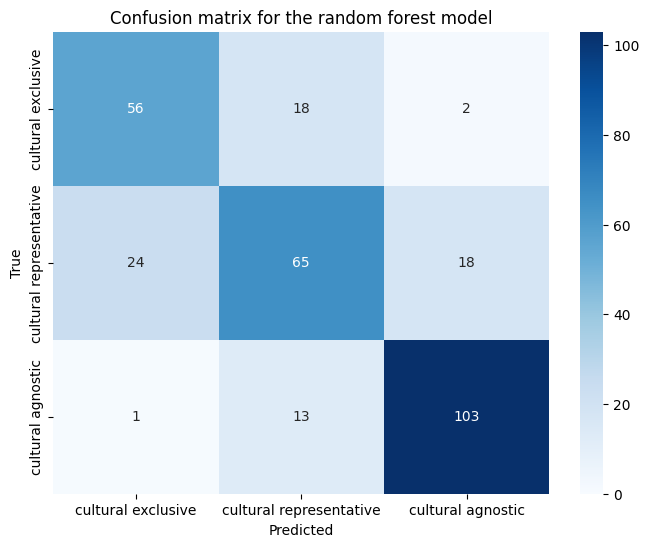

In [ ]:
# Confusion Matrix
cm_NN = confusion_matrix(y_dev_int, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for the random forest model")
plt.show()


### XGBoost

In [ ]:
# Define XGBoost model
model_XG = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train model
model_XG.fit(X_train_processed, y_train)

# Predictions
y_train_pred = model_XG.predict(X_train_processed)
y_dev_pred = model_XG.predict(X_dev_processed)

# Predictions
y_train_pred = model_XG.predict(X_train_processed)
y_dev_pred = model_XG.predict(X_dev_processed)

# Metrics
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_int, y_train_pred, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_int, y_dev_pred, average='weighted')

# Print
print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")
print(f"Train Precision: {train_precision * 100:.2f}%")
print(f"Train Recall: {train_recall * 100:.2f}%")
print(f"Train F1-score: {train_f1 * 100:.2f}%")
print(f"Dev Precision: {dev_precision * 100:.2f}%")
print(f"Dev Recall: {dev_recall * 100:.2f}%")
print(f"Dev F1-score: {dev_f1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:39:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on Train: 91.15%
Accuracy on Dev: 74.33%
Train Precision: 91.25%
Train Recall: 91.15%
Train F1-score: 91.05%
Dev Precision: 73.91%
Dev Recall: 74.33%
Dev F1-score: 74.03%


In [ ]:
# Classification report
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        76
           1       0.68      0.63      0.65       107
           2       0.83      0.89      0.86       117

    accuracy                           0.74       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.74      0.74      0.74       300



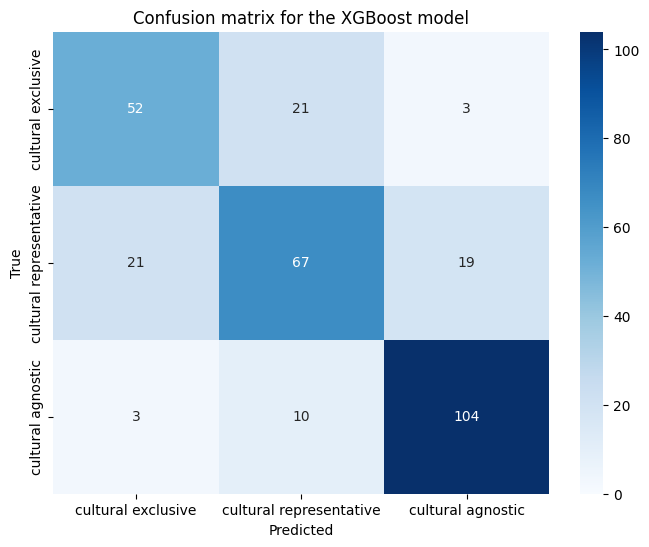

In [ ]:
# Confusion matrix
cm_NN = confusion_matrix(y_dev, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for the XGBoost model")
plt.show()


### SVM

In [ ]:
# From one hot to labels
y_train_int = np.argmax(y_train_cat, axis=1)
y_dev_int = np.argmax(y_dev_cat, axis=1)

# Model SVM and training
model_SV = SVC(kernel='rbf', probability=True)
model_SV.fit(X_train_processed, y_train_int)

# Predictions
y_train_pred = model_SV.predict(X_train_processed)
y_dev_pred = model_SV.predict(X_dev_processed)

# Predictions
y_train_pred = model_SV.predict(X_train_processed)
y_dev_pred = model_SV.predict(X_dev_processed)

# Metrics
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_int, y_train_pred, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_int, y_dev_pred, average='weighted')

# Print
print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")
print(f"Train Precision: {train_precision * 100:.2f}%")
print(f"Train Recall: {train_recall * 100:.2f}%")
print(f"Train F1-score: {train_f1 * 100:.2f}%")
print(f"Dev Precision: {dev_precision * 100:.2f}%")
print(f"Dev Recall: {dev_recall * 100:.2f}%")
print(f"Dev F1-score: {dev_f1 * 100:.2f}%")

Accuracy on Train: 75.14%
Accuracy on Dev: 73.00%
Train Precision: 74.78%
Train Recall: 75.14%
Train F1-score: 74.45%
Dev Precision: 72.79%
Dev Recall: 73.00%
Dev F1-score: 72.00%


In [ ]:
# Classification report
print(classification_report(y_dev_int, y_dev_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68        76
           1       0.73      0.52      0.61       107
           2       0.78      0.93      0.85       117

    accuracy                           0.73       300
   macro avg       0.72      0.72      0.71       300
weighted avg       0.73      0.73      0.72       300



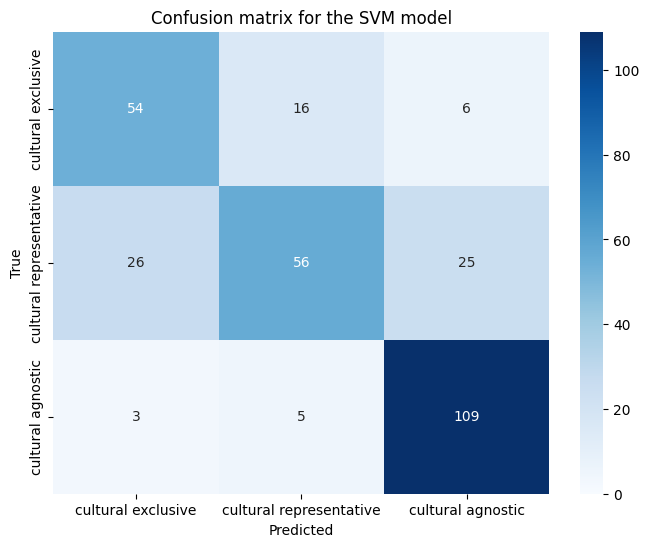

In [ ]:
# Confusion matrix
cm_NN = confusion_matrix(y_dev_int, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for the SVM model")
plt.show()


### Logistic Regression

In [ ]:
# From one hot to labels
y_train_int = np.argmax(y_train_cat, axis=1)
y_dev_int = np.argmax(y_dev_cat, axis=1)

# Model
model_LR = LogisticRegression(multi_class='multinomial', max_iter=1000)
model_LR.fit(X_train_processed, y_train_int)

# Prediction
y_train_pred = model_LR.predict(X_train_processed)
y_dev_pred = model_LR.predict(X_dev_processed)

# Predictions
y_train_pred = model_LR.predict(X_train_processed)
y_dev_pred = model_LR.predict(X_dev_processed)

# Metrics
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_int, y_train_pred, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_int, y_dev_pred, average='weighted')

# Print
print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")
print(f"Train Precision: {train_precision * 100:.2f}%")
print(f"Train Recall: {train_recall * 100:.2f}%")
print(f"Train F1-score: {train_f1 * 100:.2f}%")
print(f"Dev Precision: {dev_precision * 100:.2f}%")
print(f"Dev Recall: {dev_recall * 100:.2f}%")
print(f"Dev F1-score: {dev_f1 * 100:.2f}%")

Accuracy on Train: 74.92%
Accuracy on Dev: 76.33%
Train Precision: 74.43%
Train Recall: 74.92%
Train F1-score: 74.08%
Dev Precision: 76.44%
Dev Recall: 76.33%
Dev F1-score: 75.51%


In [ ]:
# Classification report
print(classification_report(y_dev_int, y_dev_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72        76
           1       0.78      0.58      0.67       107
           2       0.78      0.95      0.86       117

    accuracy                           0.76       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.76      0.76       300



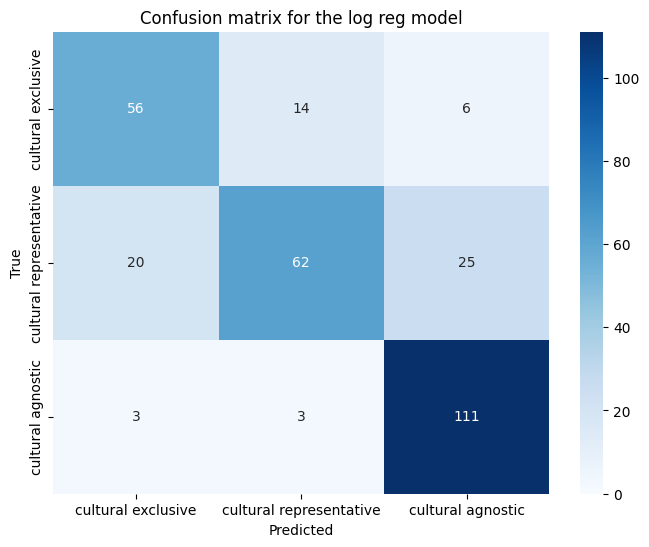

In [ ]:
# Confusion matrix
cm_NN = confusion_matrix(y_dev_int, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for the log reg model")
plt.show()

# Exportation of the ML models

In [ ]:
from huggingface_hub import login, create_repo, upload_folder
import os
import tensorflow as tf
from huggingface_hub import hf_hub_download

login(token="")

repo_name = "MNLP-HW1"
repo_id = f"tgarnier067/{repo_name}"
create_repo(repo_id, exist_ok=True, private=False)
model_folder = "models"
os.makedirs(model_folder, exist_ok=True)
models = {
    "model_logits_features": model_logits
}

# Save the models in separate files
for model_name, model in models.items():
    model_file_path = os.path.join(model_folder, f"{model_name}.keras")
    model.save(model_file_path)

# Add a default README
readme_content = """# MNLP HW1 Models
This repository contains multiple models trained for different tasks. Each model is saved as a separate `.keras` file.
"""

# Create a README.md file in the model folder
with open(os.path.join(model_folder, "README.md"), "w") as f:
    f.write(readme_content)

# Upload all models to the Hugging Face repo
upload_folder(
    repo_id=repo_id,
    folder_path=model_folder,
    path_in_repo=""
)

print(f"All models have been successfully uploaded to Hugging Face in the repo {repo_id}!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9561: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_logits_features.keras:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

All models have been successfully uploaded to Hugging Face in the repo tgarnier067/MNLP-HW1!
